In [44]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv("Electric_Vehicle_Population_By_County.csv")

In [46]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notnull()]
df = df[df['Electric Vehicle (EV) Total'].notnull()]
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

In [47]:
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['Percent Electric Vehicles'] = np.where(
    df['Percent Electric Vehicles'] > upper_bound, upper_bound,
    np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles'])
)

In [48]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

le_county = LabelEncoder()
le_state = LabelEncoder()
df['County_encoded'] = le_county.fit_transform(df['County'])
df['State_encoded'] = le_state.fit_transform(df['State'])


In [49]:
df['Electric Vehicle (EV) Total'] = df['Electric Vehicle (EV) Total'].astype(str).str.replace(',', '')
df['Electric Vehicle (EV) Total'] = pd.to_numeric(df['Electric Vehicle (EV) Total'], errors='coerce')
df = df[df['Electric Vehicle (EV) Total'].notnull()]

In [50]:
features = ['Year', 'Month', 'County_encoded', 'State_encoded']
target = 'Electric Vehicle (EV) Total'

X = df[features]
y = df[target]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [53]:
y_pred = xgb.predict(X_test)

In [56]:
print("Evaluation Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

Evaluation Metrics:
MAE: 335.53582763671875
MSE: 6179836.5
RMSE: 2485.927694040999
R² Score: 0.26362764835357666


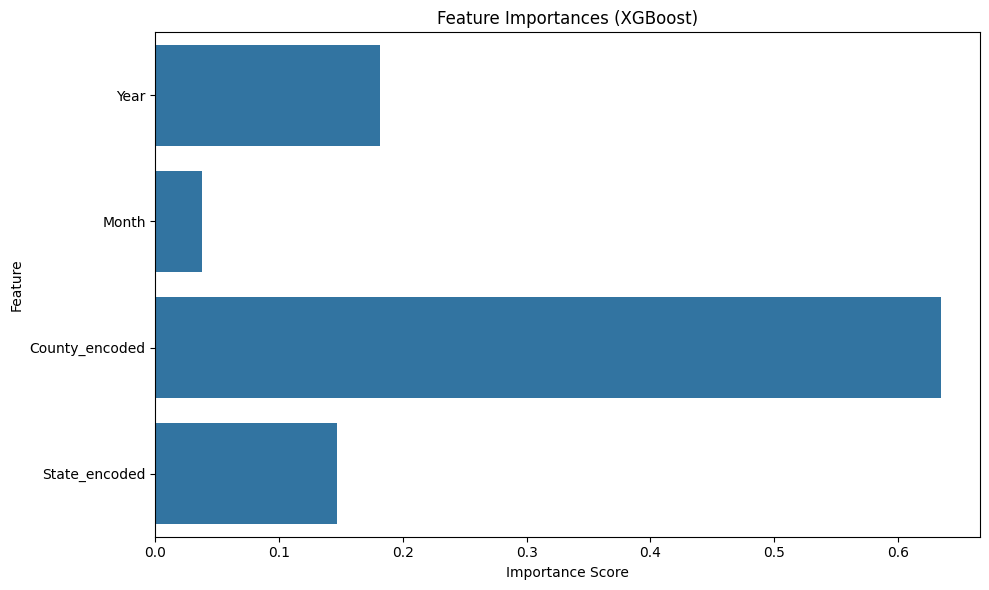

In [57]:
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb.feature_importances_, y=features)
plt.title("Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()